# Análise de Dados de Recursos Humanos

Uma empresa, através do seu setor de RH, oferece um treinamento de capacitação em tecnologia para a comunidade em geral. Através dos dados dos alunos do treinamento, a empresa quer saber quais as variáveis que mais influenciam para uma pessoa buscar um novo emprego.

In [1]:
# Importando os pacotes a serem utilizados na análise

# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno

# Estatística
import scipy
from scipy.stats import normaltest
from scipy.stats import chi2_contingency

# Engenharia de Atributos
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
#Carregar e exibir o dataset
df=pd.read_csv('aug_train.csv')
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


### Dicionário de Colunas
enrollee_id: código de identificação do aluno

city: código da cidade

city_development_index: índice de desenvolvimento da cidade

gender: gênero

relevant_experience: relevância profissional do aluno, classificada pela quantidade de anos

enrolled_university: classificação do curso universitário quanto ao período de estudo

education_level: nível de escolaridade

major_discipline: área de conhecimento da graduação

experience: experiência em anos

company_size: tamanho da companhia com relação ao número de colaboradores

company_type: tipo da empresa

last_new_job: tempo em anos que a pessoa ficou desempregada pela última vez

training_hours: tempo que a pessoa levou para concluir o treinamento

target: variável alvo, informa se a pessoa está ou não buscando um novo emprego

## Análise exploratória dos dados

In [3]:
#descrição das variáveis não numéricas
df.describe(include=object)

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,19158,14650,19158,18772,18698,16345,19093,13220,13018,18735
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,4355,13221,13792,13817,11598,14492,3286,3083,9817,8040


In [4]:
#descrição das variáveis numéricas
df.describe().drop(columns=['enrollee_id','target'])

,city_development_index,training_hours
count,19158.000000,19158.000000
mean,0.828848,65.366896
std,0.123362,60.058462
min,0.448000,1.000000
25%,0.740000,23.000000
50%,0.903000,47.000000
75%,0.920000,88.000000
max,0.949000,336.000000


Para a variável cdi, temos a média igual a 0,82 e a mediana igual a 0,90, nos indicando que a maioria dos candidatos são de cidades desenvolvidas.

Para a variável horas de treinamento, temos uma média igual a 65,36 e a mediana igual a 47,00. Isso nos informa que a maioria das pessoas concluem o treinamento em poucas horas, porém existem pessoas que demoraram muito para concluir.

Text(0.5, 1.0, 'Boxplot das Horas de Treinamento')

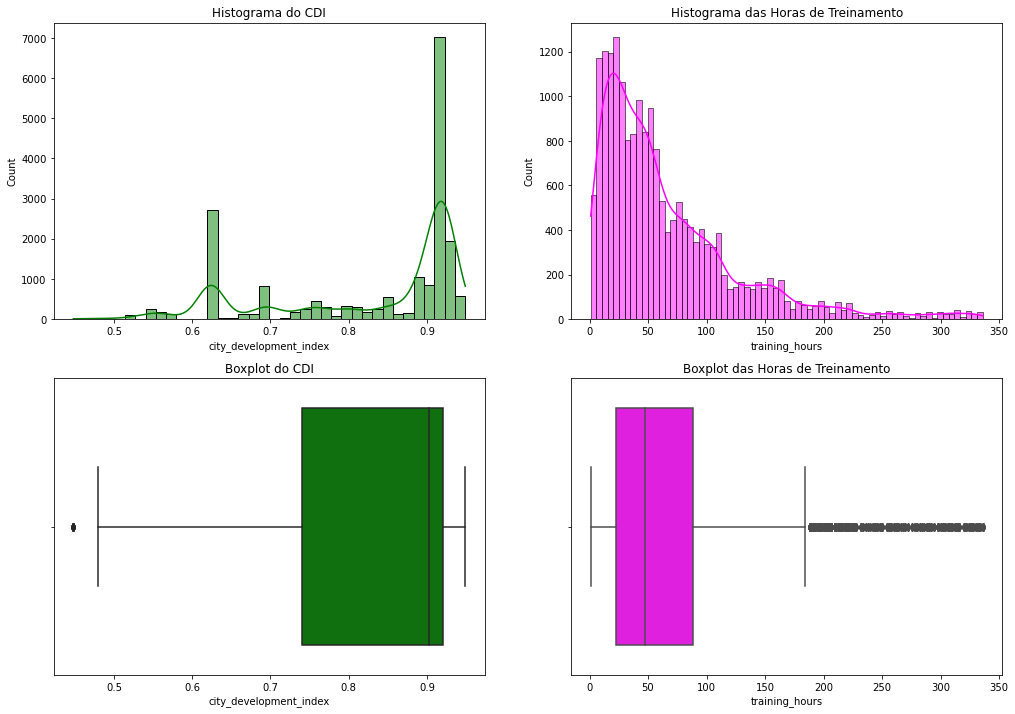

In [6]:
#visualizando a distribuição das variáveis numéricas
plt.figure(figsize=(17,12))
#histogramas
plt.subplot(221)
sns.histplot(df['city_development_index'],kde=True,color="green")
plt.title('Histograma do CDI')

plt.subplot(222)
sns.histplot(df['training_hours'],kde=True,color="magenta")
plt.title('Histograma das Horas de Treinamento')

#boxplot
plt.subplot(223)
sns.boxplot(df['city_development_index'],color="green")
plt.title('Boxplot do CDI')

plt.subplot(224)
sns.boxplot(df['training_hours'],color="magenta")
plt.title('Boxplot das Horas de Treinamento')

Através dos gráficos podemos notar que nenhum das variáveis apresentam uma distribuição normal, ou seja, apresentam média, mediana e moda com valores distintos.
Podemos notar que nas horas de treinamento há vários outliers, pessoas que por algum motivo levaram muito tempo para concluir o treinamento. No entanto, a maioria completa o treinamento em 47 horas.

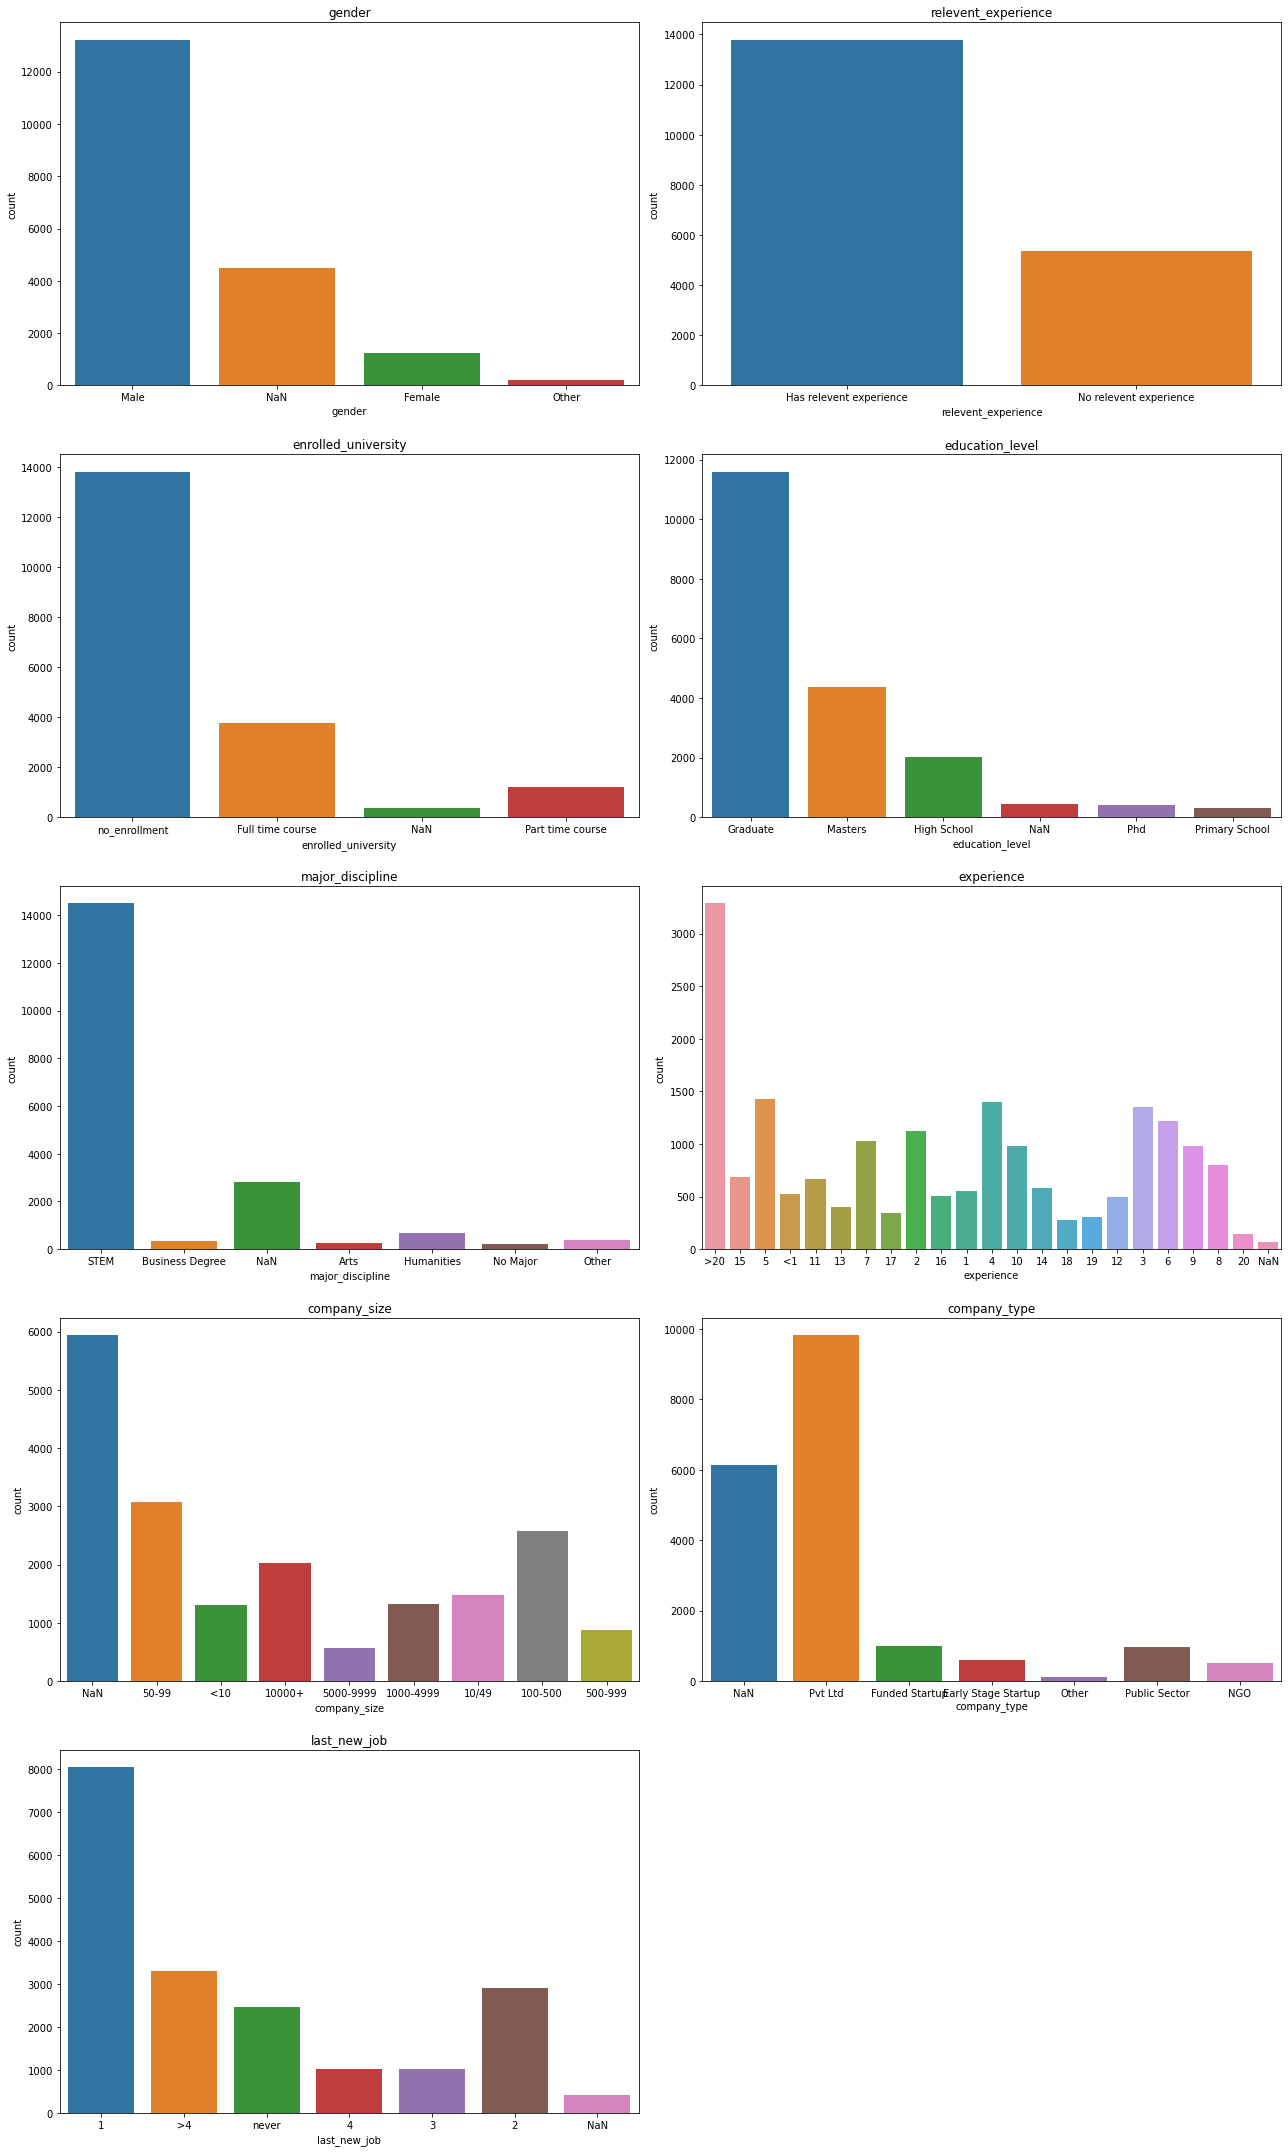

In [11]:
#visualização das variáveis não numéricas
plt.figure(figsize=(18,30))
columns=list(df.columns.values)[3:12]
a=0
for i in columns:
    a+=1
    plt.subplot(5,2,a)
    ax=sns.countplot(data=df.fillna('NaN'),x=i)
    plt.title(i)

plt.tight_layout(h_pad = 2)

## Correlação dos Dados 

Aanalisando as variáveis last_new_job e experience, podemos perceber que elas também podem ser descritas como variáveis numéricas. Assim, vamos transformá-las em variáveis numéricas e verificar a correlação com a variável target.

In [12]:
df_numerical=df.copy()

In [13]:
df_numerical['experience']=np.where(df_numerical['experience']=="<1",1,df_numerical['experience'])
df_numerical['experience']=np.where(df_numerical['experience']==">20",21,df_numerical['experience'])
df_numerical['experience']=df_numerical['experience'].astype(float)

In [14]:
df_numerical.experience.value_counts()

21.0    3286
5.0     1430
4.0     1403
3.0     1354
6.0     1216
2.0     1127
1.0     1071
7.0     1028
10.0     985
9.0      980
8.0      802
15.0     686
11.0     664
14.0     586
16.0     508
12.0     494
13.0     399
17.0     342
19.0     304
18.0     280
20.0     148
Name: experience, dtype: int64

In [15]:
df_numerical['last_new_job']=np.where(df_numerical['last_new_job']==">4",5,df_numerical['last_new_job'])
df_numerical['last_new_job']=np.where(df_numerical['last_new_job']=="never",0,df_numerical['last_new_job'])
df_numerical['last_new_job']=df_numerical['last_new_job'].astype(float)

In [16]:
df_numerical.last_new_job.value_counts()

1.0    8040
5.0    3290
2.0    2900
0.0    2452
4.0    1029
3.0    1024
Name: last_new_job, dtype: int64

Text(0.5, 1.0, 'Mapa de Correlação das Variáveis Numéricas\n')

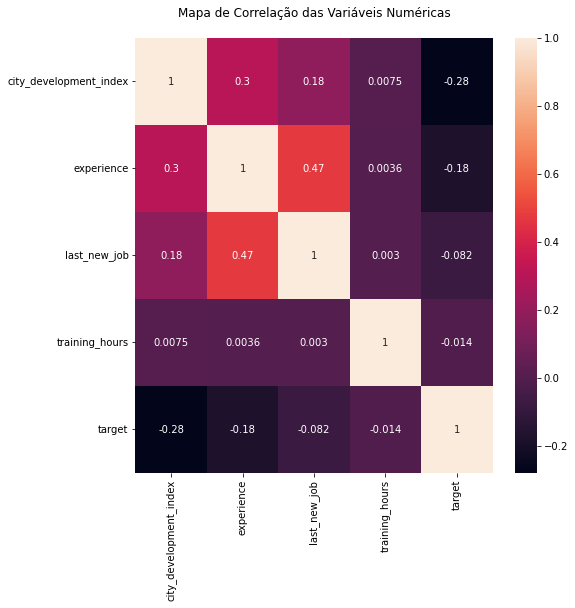

In [20]:
#mapa de calor com a correlação das variáveis numéricas
plt.figure(figsize=(8,8))
sns.heatmap(df_numerical.drop("enrollee_id",axis=1).corr("spearman"),annot=True)
plt.title("Mapa de Correlação das Variáveis Numéricas\n")

Através do mapa de calor podemos perceber que a correlação mais forte é entre as variáveis experience e last_new_job. Também vemos que as variáveis last_new_job e training_hours tem uma correlação muito fraca com a variável alvo (target), podendo até serem descartadas da análise.

# Weight of Evidence (WOE) e Information Value (IV)
Este conjunto de dados contém mais dados com tipo categórico do que tipo numérico. Usaremos recursos categóricos nominais para WOE e IV.

Weight of Evidence (WOE) e Information Value (IV) são duas medidas usadas para analisar a  força  de  uma  variável  em  relação à variável  alvo. Embora  possa  ser  usada  com  variáveis numéricas e categóricas normalmente usamos com variáveis categóricas.

WOE = percentual de eventos / percentual de não eventos

IV = sum(WOE * (percentual de eventos - percentual de não eventos)

Interpretamos o resultado de IV assim:

Information Value, Poder de Previsão

< 0.02, não deve ser usado para previsão

0.02 - 0.1, preditor fraco

0.1 - 0.3, preditor médio

0.3 - 0.5, preditor forte

maior que 0.5, parece bom demais para ser verdade

<Figure size 720x864 with 0 Axes>

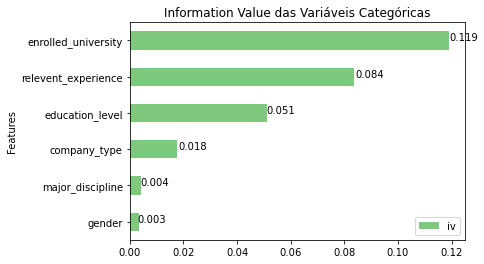

In [21]:
# Variáveis categóricas
columns_cat = df.drop(columns = ['target',
                                 'enrollee_id',
                                 'city',
                                 'city_development_index',
                                 'training_hours',
                                 'experience',
                                 'last_new_job',
                                 'company_size']).columns

# Lista para o IV
iv = []

# Loop
for i in columns_cat:
    df_woe_iv = (pd.crosstab(df[i], df['target'], normalize = 'columns')
                 .assign(woe = lambda dfx: np.log(dfx[1] / dfx[0]))
                 .assign(iv = lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
    iv.append(df_woe_iv['iv'][0])

# Dataframe
df_iv = pd.DataFrame({'Features':columns_cat,'iv':iv}).set_index('Features').sort_values(by = 'iv')

# Plot
# Figura
plt.figure(figsize = (10,12))
df_iv.plot(kind = 'barh', title = 'Information Value das Variáveis Categóricas', colormap = "Accent")
for index, value in enumerate(list(round(df_iv["iv"],3))):
    plt.text((value), index, str(value))
plt.legend(loc  = "lower right")
plt.show()

Através do gráfico notamos que a variável enrolled_university é um preditor médio, relevant_experience e education_level são preditores fracos e as outras variáveis são inúteis para a previsão.

Text(0.5, 1.0, 'Gráfico de Desbalanceamento da Variável Target')

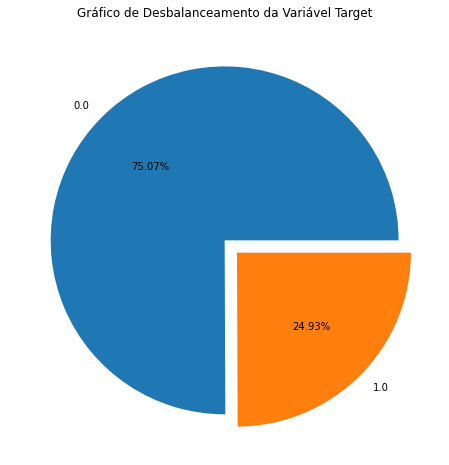

In [23]:
#verificando o desbalanceamento dos dados
plt.figure(figsize=(8,8))
plt.pie(df.target.value_counts(),labels = list(df['target'].value_counts().index),
        autopct = "%.2f%%",
        explode = (0,0.1))
plt.title('Gráfico de Desbalanceamento da Variável Target')

Nota-se que a grande maioria dos dados (75%) são de pessoas que naõ estão buscando um novo emprego. Para o trabalho apenas de análise naõ há problema, mas se fossemos fazer previsões com Machine Learning precisaríamos buscar uma forma de tornar os dados mais balanceados.

## Limpeza e Processamento dos Dados

In [25]:
#verificando valores duplicados
df['enrollee_id'].duplicated().sum()

0

In [26]:
#valores ausentes por coluna
df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [27]:
#como a variável gênero é inútil na previsão, vamos fazer o drop dela
df=df.drop(columns=['gender'])
df

,enrollee_id,city,city_development_index,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


### Variável enrolled_university 

In [32]:
df['enrolled_university'].fillna('NaN').value_counts()

no_enrollment       13817
Full time course     3757
Part time course     1198
NaN                   386
Name: enrolled_university, dtype: int64

In [33]:
#relação entre enrolled_university e education_level
df[df['enrolled_university'].isna()]['education_level'].value_counts(dropna=False)

Graduate          171
NaN               100
Masters            53
High School        47
Primary School      9
Phd                 6
Name: education_level, dtype: int64

In [34]:
#colocamos os valores ausentes como 'Other'
nan_index=df[(df['enrolled_university'].isna())].index
df['enrolled_university'][nan_index]='Other'

In [35]:
df['enrolled_university'].value_counts()

no_enrollment       13817
Full time course     3757
Part time course     1198
Other                 386
Name: enrolled_university, dtype: int64

### Variável education_level 

In [36]:
df['education_level'].fillna('NaN').value_counts()

Graduate          11598
Masters            4361
High School        2017
NaN                 460
Phd                 414
Primary School      308
Name: education_level, dtype: int64

In [37]:
nan_index=df[(df['education_level'].isna())].index
df['education_level'][nan_index]='Other'

In [38]:
df['education_level'].value_counts()

Graduate          11598
Masters            4361
High School        2017
Other               460
Phd                 414
Primary School      308
Name: education_level, dtype: int64

### Variável major_discipline 

In [39]:
df['major_discipline'].fillna('NaN').value_counts()

STEM               14492
NaN                 2813
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64

In [40]:
#relação entre major_discipline e education_level
df[df['major_discipline'].isna()]['education_level'].value_counts(dropna=False)

High School       2017
Other              460
Primary School     308
Graduate            22
Masters              6
Name: education_level, dtype: int64

In [43]:
nan_index=df[(df['major_discipline'].isna()) & ((df['education_level']=='High School') | (df['education_level']=='Other') | (df['education_level']=='Primary School'))].index

In [44]:
df['major_discipline'][nan_index]='Non Degree'

In [45]:
df['major_discipline'].fillna('NaN').value_counts()

STEM               14492
Non Degree          2785
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
NaN                   28
Name: major_discipline, dtype: int64

In [46]:
df['major_discipline'][df[(df['major_discipline'].isna())].index]='Other'

In [47]:
df['major_discipline'].fillna('NaN').value_counts()

STEM               14492
Non Degree          2785
Humanities           669
Other                409
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64

# Variável company_size

In [49]:
df['company_size'].fillna('NaN').value_counts()

NaN          5938
50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64

In [50]:
df['company_size'][df[(df['company_size'].isna())].index]='Other'

### Variável company_type 

In [51]:
df['company_type'].fillna('NaN').value_counts()

Pvt Ltd                9817
NaN                    6140
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: company_type, dtype: int64

In [52]:
df['company_type'][df[(df['company_type'].isna())].index]='Other'

# Drop das variáveis last_new_job e training_hours

Vimos no mapa de correlação que as variáveis last_new_job e training_hours tem uma correlação muito baixa com a variável target, logo vamos fazer o drop dessas variáveis.

In [54]:
df=df.drop(columns=['last_new_job','training_hours'])

In [56]:
df.isna().sum()

enrollee_id                0
city                       0
city_development_index     0
relevent_experience        0
enrolled_university        0
education_level            0
major_discipline           0
experience                65
company_size               0
company_type               0
target                     0
dtype: int64

Restaram apenas os valores ausentes da variável experience, que presentam 0,33% da massa de dados. Segundo a literatura, se tivermos menos de 2% de valores ausentes, podemos apagar esses dados. Então faremos o drop desses dados.

In [57]:
df=df.dropna()

In [58]:
df.isna().sum()

enrollee_id               0
city                      0
city_development_index    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
target                    0
dtype: int64

In [59]:
df.head()

,enrollee_id,city,city_development_index,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,target
0,8949,city_103,0.920,Has relevent experience,no_enrollment,Graduate,STEM,>20,Other,Other,1.0
1,29725,city_40,0.776,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,0.0
2,11561,city_21,0.624,No relevent experience,Full time course,Graduate,STEM,5,Other,Other,0.0
3,33241,city_115,0.789,No relevent experience,Other,Graduate,Business Degree,<1,Other,Pvt Ltd,1.0
4,666,city_162,0.767,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,0.0


# Relatório Final

Com base na análise podemos observar que as variáveis que podem ser utilizadas para encontrar um bom candidato são:

-Índice de desenvolvimento da cidade;

-Experiência do candidato;

-Se tem ou não experiência relevante;

-Se está matriculado ou não num curso universitário;

-Nível educacional;

-Área de graduação (quando for o caso);

-Tipo da empresa.


Não são relevante para a análise:

-Gênero;

-Horas de treinamento;

-Última vez que o candidato esteve desempregado;

-Tamanho da empresa;

-ID do candidato;

-Código da cidade.